# Skin Type Model
This model is the model that used to classify user's skin type and have an output of multi-class from 3 possible class (oily,normal,dry)

## Import Libraries, Mobilenet, and Env File

In [1]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Importing Env File
from dotenv import load_dotenv

load_dotenv()
datasets_path = os.getenv('DATASET_PATH_TYPE_2')
# datasets_path = os.getenv('DATASET_PATH_TYPE_3')

In [3]:
# Importing MobileNetV2 RestNet With ImagNet Weight Without The Top Layer
from tensorflow.keras.applications import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [4]:
# Membekukan semua lapisan dari model MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Fine-tuning: Membuka beberapa lapisan terakhir dari MobileNetV2
for layer in base_model.layers[-5:]:  # Mengatur lebih banyak lapisan terakhir dapat dilatih
    layer.trainable = True

## Importing Model (If Exist)

In [2]:
from tensorflow.keras.models import load_model

# load model from .h5 file
model = load_model('models/skin_type_model_2.keras')

c:\Users\albia\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Import Dataset

In [5]:
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import tensorflow as tf

class SkinTypeDataset(tfds.core.GeneratorBasedBuilder):
    """DatasetBuilder for skin type detection."""
    VERSION = tfds.core.Version('1.0.0')
    MANUAL_DOWNLOAD_INSTRUCTIONS = "Please ensure the skin type dataset is downloaded and located at the right path (look at env file)"

    def _info(self):
        return tfds.core.DatasetInfo(
            builder=self,
            description=("Dataset for skin type classification with 3 labels: oily, normal, dry"),
            features=tfds.features.FeaturesDict({
                'image': tfds.features.Image(shape=(224, 224, 3)),
                'label': tfds.features.Tensor(shape=(3,), dtype=tf.float32),
            }),
            supervised_keys=('image', 'label'),
        )

    def _split_generators(self, dl_manager):
        path = dl_manager.manual_dir
        # Read all images and labels
        all_data = []
        for category in ['oily', 'normal', 'dry']:
            category_path = os.path.join(path, category)
            for filename in os.listdir(category_path):
                all_data.append((filename, category))
        
        # Create DataFrame
        df = pd.DataFrame(all_data, columns=['filename', 'label'])
        
        # Split data into train, val, and test
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
        train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 of train for validation
        
        return {
            'train': self._generate_examples(train_df, path),
            'val': self._generate_examples(val_df, path),
            'test': self._generate_examples(test_df, path),
        }

    def _generate_examples(self, dataframe, base_path):
        label_map = {
            'oily': [1, 0, 0],
            'normal': [0, 1, 0],
            'dry': [0, 0, 1]
        }
        # Load images and their labels
        for _, row in dataframe.iterrows():
            image_path = os.path.join(base_path, row['label'], row['filename'])
            image = tf.io.read_file(image_path)  # Read image file
            image = tf.io.decode_image(image, channels=3)  # Decode image to tensor
            image = tf.image.resize(image, (224, 224))  # Resize image
            image = tf.cast(image, tf.uint8)  # Convert to uint8
            label = tf.cast(label_map[row['label']], tf.float32)  # Cast to float32
            yield row['filename'], {  # Use filename as the unique key
                'image': image.numpy(),
                'label': label.numpy(),
            }

# Use the updated dataset class
builder = SkinTypeDataset(data_dir=datasets_path)
builder.download_and_prepare()

## Checking Dataset

In [6]:
# Memuat dataset dalam bentuk builder untuk melakukan cek
ds_train = builder.as_dataset(split='train')
ds_val = builder.as_dataset(split='val')
ds_test = builder.as_dataset(split='test')

In [7]:
# Filter dan tampilkan label dengan nilai [0, 0, 1]
for i, example in enumerate(ds_train):
    label = example['label'].numpy()  # Ambil label sebagai numpy array
    if (label == [0, 0, 1]).all():    
        print(f"Label {i + 1}: {label}")

Label 1: [0. 0. 1.]
Label 2: [0. 0. 1.]
Label 3: [0. 0. 1.]
Label 7: [0. 0. 1.]
Label 11: [0. 0. 1.]
Label 12: [0. 0. 1.]
Label 13: [0. 0. 1.]
Label 14: [0. 0. 1.]
Label 17: [0. 0. 1.]
Label 32: [0. 0. 1.]
Label 34: [0. 0. 1.]
Label 41: [0. 0. 1.]
Label 46: [0. 0. 1.]
Label 52: [0. 0. 1.]
Label 53: [0. 0. 1.]
Label 55: [0. 0. 1.]
Label 57: [0. 0. 1.]
Label 63: [0. 0. 1.]
Label 67: [0. 0. 1.]
Label 69: [0. 0. 1.]
Label 71: [0. 0. 1.]
Label 77: [0. 0. 1.]
Label 78: [0. 0. 1.]
Label 81: [0. 0. 1.]
Label 83: [0. 0. 1.]
Label 84: [0. 0. 1.]
Label 87: [0. 0. 1.]
Label 88: [0. 0. 1.]
Label 90: [0. 0. 1.]
Label 91: [0. 0. 1.]
Label 97: [0. 0. 1.]
Label 107: [0. 0. 1.]
Label 110: [0. 0. 1.]
Label 112: [0. 0. 1.]
Label 114: [0. 0. 1.]
Label 123: [0. 0. 1.]
Label 125: [0. 0. 1.]
Label 135: [0. 0. 1.]
Label 138: [0. 0. 1.]
Label 145: [0. 0. 1.]
Label 146: [0. 0. 1.]
Label 148: [0. 0. 1.]
Label 153: [0. 0. 1.]
Label 156: [0. 0. 1.]
Label 160: [0. 0. 1.]
Label 161: [0. 0. 1.]
Label 163: [0. 0. 1.]
L

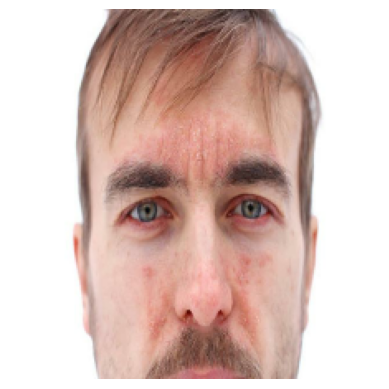

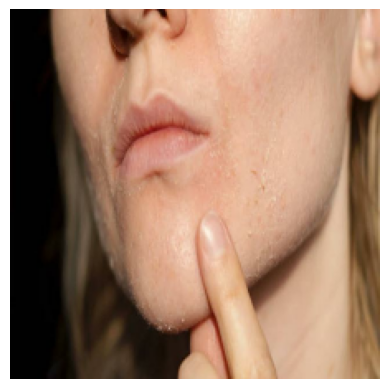

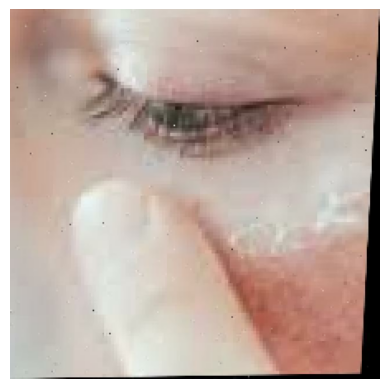

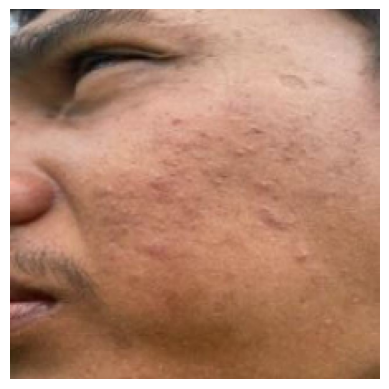

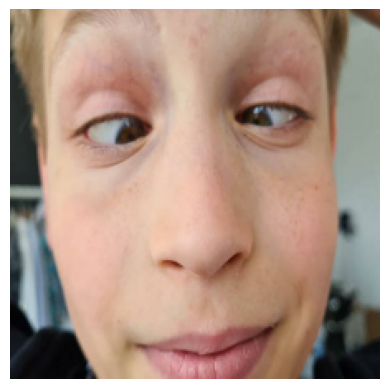

In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Fungsi untuk menampilkan gambar
def show_image(image):
    # Konversi gambar tensor ke numpy array dan tampilkan dengan matplotlib
    image = image.numpy()  # Ubah tensor menjadi numpy array
    plt.imshow(image)
    plt.axis('off')  # Nonaktifkan axis
    plt.show()

# Fungsi untuk menampilkan beberapa gambar
def show_images_from_dataset(dataset, num_images=5):
    for i, data in enumerate(dataset.take(num_images)):  # Ambil beberapa gambar pertama dari dataset
        image = data['image']
        # Tampilkan gambar
        show_image(image)

# Menampilkan gambar pertama dari ds_train
show_images_from_dataset(ds_train, num_images=5)

## Loading The Dataset And Data Augmentation


In [6]:
# Memuat dataset yang sudah diproses
ds_train = tfds.load('skin_type_dataset', split='train', data_dir=datasets_path)
ds_val = tfds.load('skin_type_dataset', split='val', data_dir=datasets_path)
ds_test = tfds.load('skin_type_dataset', split='test', data_dir=datasets_path)

In [7]:
def augment_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    
    # Menambahkan random zoom
    scale = tf.random.uniform(shape=[], minval=0.8, maxval=1.2, dtype=tf.float32)
    new_height = tf.cast(scale * 224, tf.int32)
    new_width = tf.cast(scale * 224, tf.int32)
    image = tf.image.resize(image, (new_height, new_width))
    image = tf.image.resize_with_crop_or_pad(image, 224, 224)  # Mengembalikan ke ukuran 224x224
    
    return image, label

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Function to ensure data is paired as (image, label)
def preprocess(data):
    image = data['image']
    label = data['label']
    return image, label

# Apply preprocessing and augmentation
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch the datasets
ds_train = ds_train.batch(16).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(16).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(16).prefetch(tf.data.AUTOTUNE)

In [9]:
# Hitung jumlah data dalam ds_train
num_samples = sum(1 for _ in ds_train)
# num_samples = sum(1 for _ in ds_train.unbatch())

print(f"Jumlah gambar dan label dalam ds_train: {num_samples}")

Jumlah gambar dan label dalam ds_train: 48


## Creating The Model

In [10]:
from tensorflow.keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Menambahkan lapisan kustom di atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(256, kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = ReLU()(x)  
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Menggunakan softmax untuk multi-class classification

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=outputs)

# Menyesuaikan optimizer dan learning rate 
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9) 
# Compiling the model 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Show Model Architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,114,051 (91.99 MB)

 Trainable params: 525,827 (2.01 MB)

 Non-trainable params: 23,588,224 (89.98 MB)

In [11]:
for image, label in ds_train.take(1):
    print(image.shape, label.shape)  # Pastikan gambar memiliki shape ((batch size), 224, 224, 3)

(16, 224, 224, 3) (16, 3)


## Callbacks

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callback untuk menghentikan pelatihan jika validasi loss tidak membaik
early_stopping = EarlyStopping(
    monitor='val_loss',                  
    patience=5,                         
    restore_best_weights=True,           
    verbose=1                            
)

# Callback untuk mengurangi learning rate jika validasi loss stagnan
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',                
    factor=0.5,                         
    patience=3,                         
    verbose=1                           
)

## Train Model

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 34s 618ms/step - accuracy: 0.2962 - loss: 6.2526 - val_accuracy: 0.4471 - val_loss: 5.6726 - learning_rate: 1.0000e-04
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 530ms/step - accuracy: 0.4178 - loss: 5.9411 - val_accuracy: 0.4824 - val_loss: 5.5881 - learning_rate: 1.0000e-04
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 524ms/step - accuracy: 0.4843 - loss: 5.7136 - val_accuracy: 0.5882 - val_loss: 5.4726 - learning_rate: 1.0000e-04
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 526ms/step - accuracy: 0.5618 - loss: 5.5832 - val_accuracy: 0.5765 - val_loss: 5.4685 - learning_rate: 1.0000e-04
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 520ms/step - accuracy: 0.5704 - loss: 5.5124 - val_accuracy: 0.6078 - val_loss: 5.3772 - learning_rate: 1.0000e-04
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - accuracy: 0.5924 - loss: 5.4569 - val_accuracy: 0.6157 - val_loss: 5.3990 - learning_rate: 1.0000e-04
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 514ms/step - acc

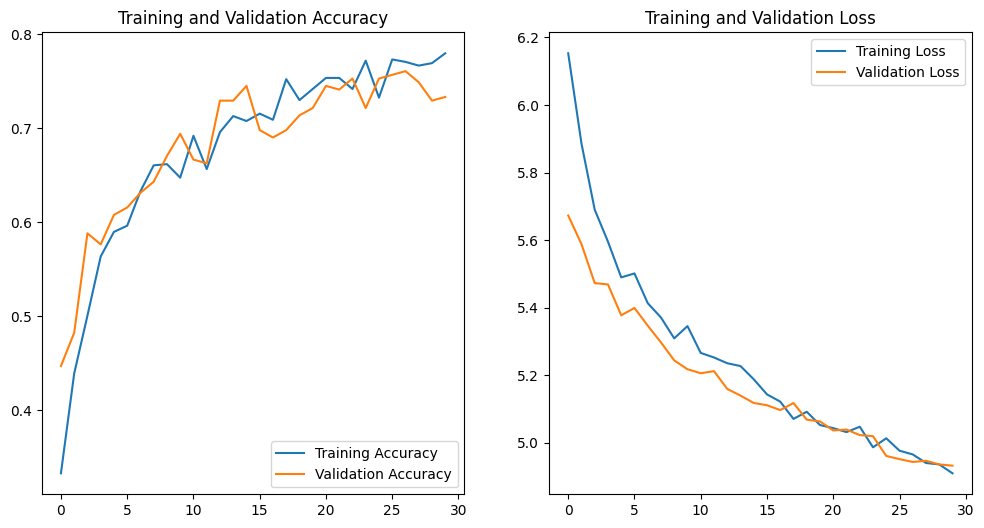

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step - accuracy: 0.7962 - loss: 4.7997
Testing Loss: 4.795767307281494, Testing Accuracy: 0.8313725590705872


In [13]:
# class_weight = {0: 0.6 , 1: 1.2 , 2: 0.6}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')


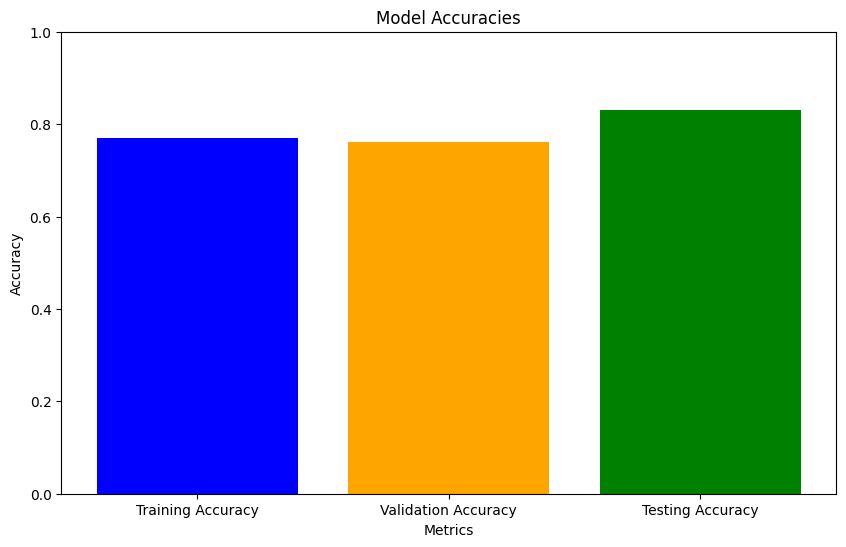

In [14]:
# Ambil nilai akurasi pada epoch terbaik
best_epoch = np.argmax(history.history['val_accuracy'])

train_accuracy = history.history['accuracy'][best_epoch] 
val_accuracy = history.history['val_accuracy'][best_epoch]

# Akurasi data testing (sudah didapat dari evaluasi model sebelumnya)
test_accuracy = accuracy

# Buat bar chart
labels = ['Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
accuracies = [train_accuracy, val_accuracy, test_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Atur batas y dari 0 sampai 1
plt.xlabel('Metrics')
plt.ylabel('Accuracy')
plt.title('Model Accuracies')
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step


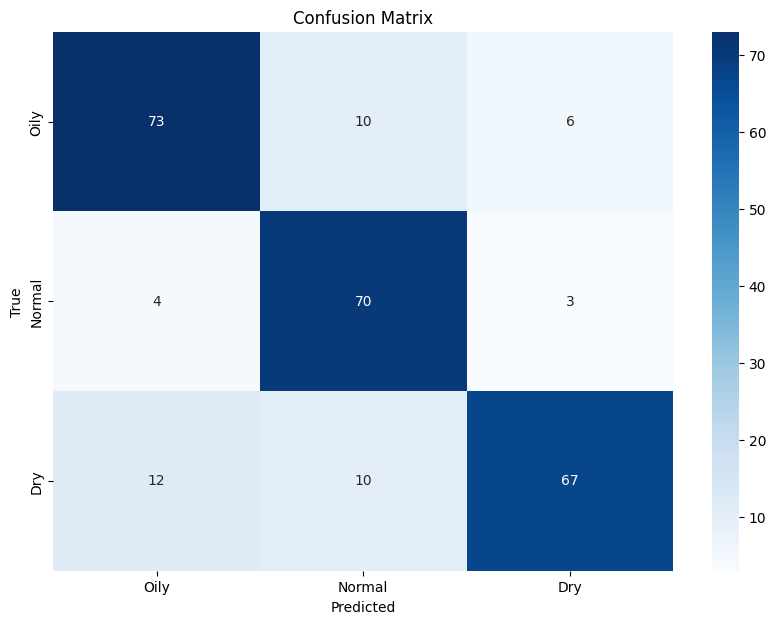

              precision    recall  f1-score   support

        Oily       0.82      0.82      0.82        89
      Normal       0.78      0.91      0.84        77
         Dry       0.88      0.75      0.81        89

    accuracy                           0.82       255
   macro avg       0.83      0.83      0.82       255
weighted avg       0.83      0.82      0.82       255



In [15]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Oily', 'Normal', 'Dry'], yticklabels=['Oily', 'Normal', 'Dry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes, target_names=['Oily', 'Normal', 'Dry']))


In [20]:
# Saving the model in .h5 format
model.save('models/skin_type_model.h5')

In [21]:
import tensorflow as tf

# Load model dari file .keras
model = tf.keras.models.load_model('models/skin_type_model.keras')

# Buat converter untuk mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('models/skin_type_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpugjlspty\assets


INFO:tensorflow:Assets written to: C:\Users\albia\AppData\Local\Temp\tmpugjlspty\assets


Saved artifact at 'C:\Users\albia\AppData\Local\Temp\tmpugjlspty'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1792318270800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318270224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318271376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318270992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318264464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318262736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318272912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318273488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318273872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1792318269840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  179231

## Training Lanjutan (Rawan Overfitting)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 538ms/step - accuracy: 0.7950 - loss: 4.8608 - val_accuracy: 0.7765 - val_loss: 4.8804 - learning_rate: 1.0000e-04
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 519ms/step - accuracy: 0.7921 - loss: 4.8874 - val_accuracy: 0.7451 - val_loss: 4.8824 - learning_rate: 1.0000e-04
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 524ms/step - accuracy: 0.7558 - loss: 4.8811 - val_accuracy: 0.7686 - val_loss: 4.9033 - learning_rate: 1.0000e-04
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.7557 - loss: 4.8832
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 26s 538ms/step - accuracy: 0.7561 - loss: 4.8826 - val_accuracy: 0.7647 - val_loss: 4.8811 - learning_rate: 1.0000e-04
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 532ms/step - accuracy: 0.7913 - loss: 4.8108 - val_accuracy: 0.7843 - val_loss: 4.8295 - learning_rate: 5.0000e-05
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 24s 511ms/step - accuracy:

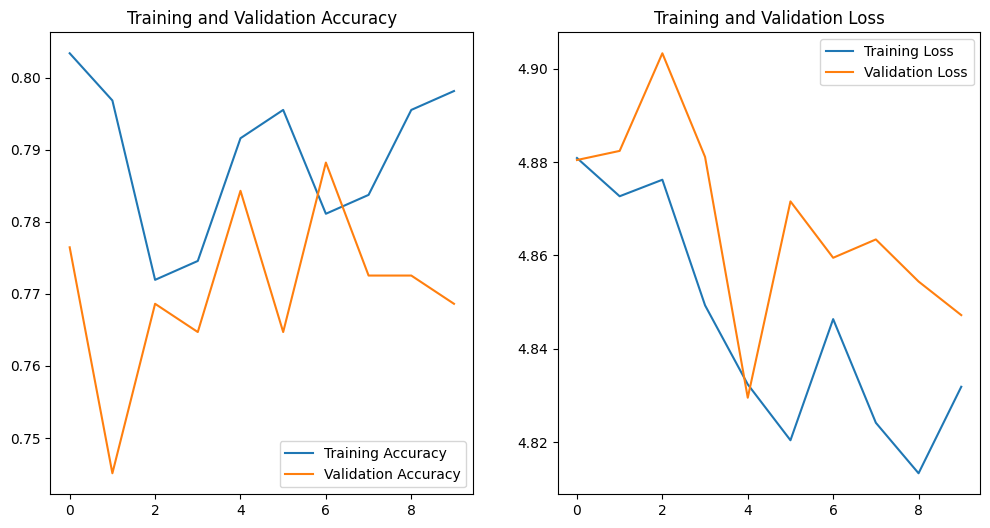

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 383ms/step - accuracy: 0.8049 - loss: 4.7275
Testing Loss: 4.756502151489258, Testing Accuracy: 0.7960784435272217


In [17]:
# class_weight = {0: 0.6 , 1: 1.2 , 2: 0.6}  # Sesuaikan bobot berdasarkan kinerja kelas

# Melatih model dan mencatat hasil pelatihan dalam objek `history`
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10,
    # class_weight=class_weight,
    callbacks=[early_stopping, lr_scheduler] 
)

# Menampilkan metrik dengan matplotlib
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(accuracy))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi model pada data testing
loss, accuracy = model.evaluate(ds_test)
print(f'Testing Loss: {loss}, Testing Accuracy: {accuracy}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 397ms/step


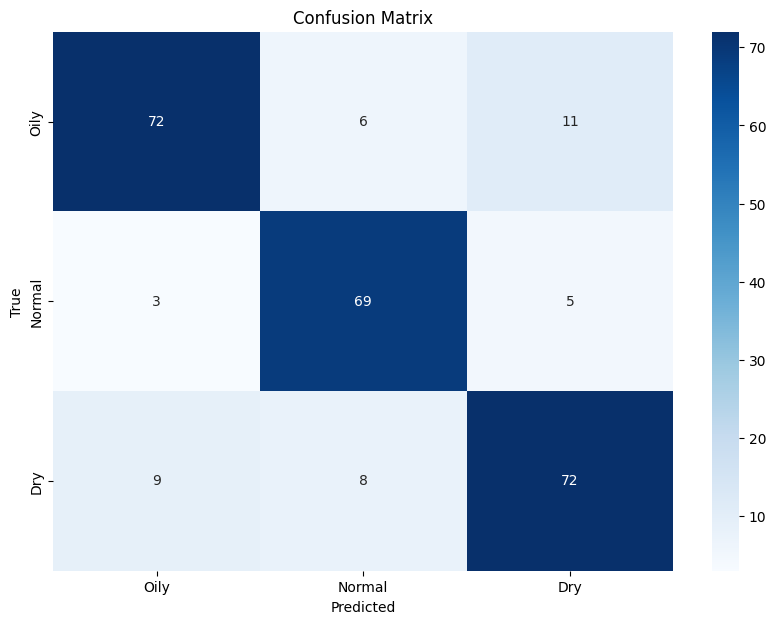

              precision    recall  f1-score   support

        Oily       0.86      0.81      0.83        89
      Normal       0.83      0.90      0.86        77
         Dry       0.82      0.81      0.81        89

    accuracy                           0.84       255
   macro avg       0.84      0.84      0.84       255
weighted avg       0.84      0.84      0.83       255



In [18]:
# Membuat prediksi pada data testing
y_pred = model.predict(ds_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Mendapatkan label aktual
y_true = np.concatenate([y for x, y in ds_test], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Menampilkan confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Oily', 'Normal', 'Dry'], yticklabels=['Oily', 'Normal', 'Dry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan laporan klasifikasi
print(classification_report(y_true_classes, y_pred_classes, target_names=['Oily', 'Normal', 'Dry']))